In [1]:
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("CarlAxel@1417")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)


Anslutning till SQL Server lyckades


C:\Users\marcu\AppData\Local\Temp\ipykernel_30836\3423618423.py:21: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql),conn)


# -------------------Uppgift 1 & 2-------------------
1. **Hur många produkter finns i varje kategori?** (Antal produkter per kategori)
2. **Vilka produktkategorier genererar mest intäkter?** (Försäljning per produktkategori)

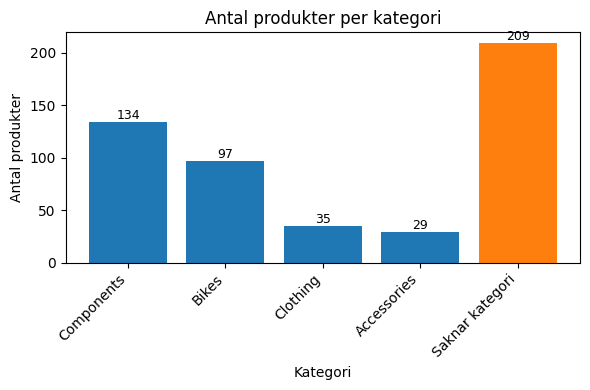

,Kategori,SummaKategori
0,Bikes,"$94,651,173"
1,Components,"$11,802,593"
2,Clothing,"$2,120,543"
3,Accessories,"$1,272,073"


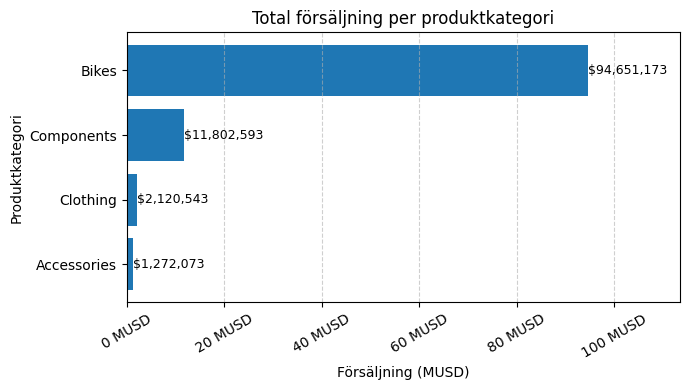

In [3]:
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## Uppgift 1:
## Antal produkter per kategori
## Affärsfråga: Hur många produkter finns i varje kategori?

query_1 = """
SELECT 
    COALESCE (pc.Name, 'Saknar kategori') AS Kategori,
    COUNT(p.ProductID) AS AntalProdukter
FROM 
    Production.Product p
LEFT JOIN Production.ProductSubcategory ps 
    ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc 
    ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY 
    COALESCE(pc.Name, 'Saknar kategori')
ORDER BY 
    CASE WHEN COALESCE(pc.Name, 'Saknar kategori') = 'Saknar kategori' THEN 1 ELSE 0 END,
    AntalProdukter DESC
"""
query_1_df = query_df(query_1)
# display(query_1_df)

colors = [
    "tab:orange" if kategori == "Saknar kategori" else "tab:blue"
    for kategori in query_1_df["Kategori"]
]
plt.figure(figsize=(6, 4))
bars = plt.bar(query_1_df["Kategori"], query_1_df["AntalProdukter"], color=colors)
plt.title("Antal produkter per kategori")
plt.xlabel("Kategori")
plt.ylabel("Antal produkter")
plt.xticks(rotation=45, ha="right")

#Etiketter
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{int(height)}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

## Uppgift 2:
## Försäljning per produktkategori
## Affärsfråga: Vilka produktkategorier genererar mest intäkter?

query_2 = """
SELECT 
    COALESCE (pc.Name, 'Saknar kategori') AS Kategori,
    SUM(LineTotal) AS SummaKategori
FROM 
    Sales.SalesOrderDetail sod
INNER JOIN Production.Product p
    ON sod.ProductID = p.ProductID
LEFT JOIN Production.ProductSubcategory ps 
    ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc 
    ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY 
    COALESCE(pc.Name, 'Saknar kategori')
ORDER BY 
    CASE WHEN COALESCE(pc.Name, 'Saknar kategori') = 'Saknar kategori' THEN 1 ELSE 0 END,
    SummaKategori DESC;
"""

query_2_df = query_df(query_2)
display(query_2_df.style.format({"SummaKategori": "${:,.0f}"}).set_caption("Försäljning per produktkategori (USD)"))

fig, ax = plt.subplots(figsize=(7, 4))

bars = ax.barh(
    query_2_df["Kategori"],
    query_2_df["SummaKategori"]
)

ax.set_title("Total försäljning per produktkategori")
ax.set_xlabel("Försäljning (MUSD)")
ax.set_ylabel("Produktkategori")

# Högsta värdet överst
ax.invert_yaxis()

# Vertikala hjälplinjer
ax.grid(axis="x", linestyle="--", alpha=0.6)

#Formattering x-axel

ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.0f} MUSD")
)
ax.tick_params(axis="x", rotation=30)

# Extra utrymme så texten inte kapas
max_value = query_2_df["SummaKategori"].max()
ax.set_xlim(0, max_value * 1.2)

# Lägg exakta värden på staplarna
for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"${width:,.0f}",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.show()

##Försäljningstrend över tid
##Affärsfråga: Hur har försäljningen utvecklats över tid?


## Slutsats

**Produkter per kategori**
Diagrammet visar att den största gruppen produkter återfinns i kategorin Saknar kategori. Dessa produkter har dock ingen registrerad försäljning, vilket tyder på att kategorisering sannolikt sker först när en produkt faktiskt säljs eller aktiveras i sortimentet. Därför är denna kategori mindre relevant ur ett försäljningsperspektiv.

Bland de kategoriserade produkterna har Components flest produkter. Detta är rimligt eftersom en cykel består av många olika komponenter (t.ex. bromsar, växlar och hjul), vilket naturligt leder till ett bredare sortiment inom denna kategori. Därefter följer Bikes, som också har ett relativt stort antal produkter men färre än Components.

Clothing och Accessories har färre produkter, vilket är rimligt då båda fungerar som komplement till huvudprodukterna (cyklar och komponenter) snarare än som kärnan i sortimentet.

**Försäljning per produktkategori**
Bikes står för den klart största delen av försäljningen med cirka 94,6 miljoner dollar, följt av Components med 11,8 miljoner dollar. Detta är rimligt eftersom en komponent generellt är betydligt billigare än en hel cykel. Accessories har den lägsta försäljningen och står för endast 1,2 miljoner dollar, vilket bekräftar att tillbehör främst fungerar som ett komplement snarare än som huvudintäktskälla.


# -------------------Uppgift 3-------------------
**Hur har försäljningen utvecklats över tid?** (Försäljningstrend över tid)


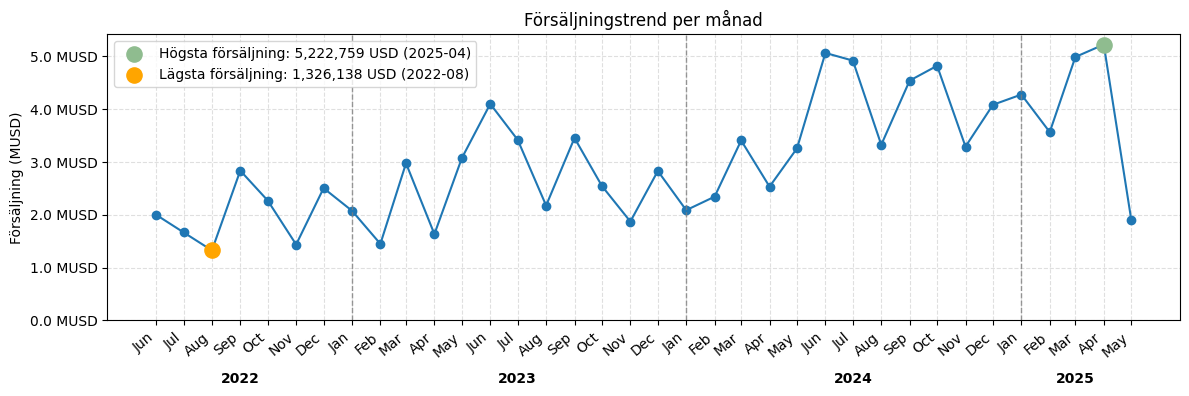

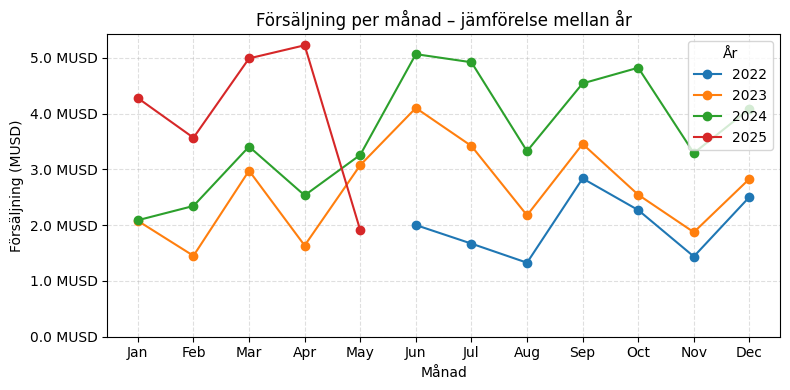

In [4]:
## Uppgift
## Försäljningstrend över tid
## Affärsfråga: Hur har försäljningen utvecklats över tid?

query_3 ="""
SELECT
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS OrderMonth,
    SUM(SubTotal) AS TotalForsaljning,
    MIN(CAST(OrderDate AS date)) AS FirstOrderDateInMonth,
    MAX(CAST(OrderDate AS date)) AS LastOrderDateInMonth,
    CASE
        WHEN MIN(CAST(OrderDate AS date)) = DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
         AND MAX(CAST(OrderDate AS date)) = EOMONTH(DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1))
        THEN 1 ELSE 0
    END AS IsFullMonth
FROM Sales.SalesOrderHeader
GROUP BY DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
ORDER BY OrderMonth;
""" 
query_3_df = query_df(query_3)
#query_3_df.head()
#print(query_3_df.dtypes)

#Gör om datumkolumner från object till datetime
query_3_df["OrderMonth"] = pd.to_datetime(query_3_df["OrderMonth"])
query_3_df["FirstOrderDateInMonth"] = pd.to_datetime(query_3_df["FirstOrderDateInMonth"])
query_3_df["LastOrderDateInMonth"] = pd.to_datetime(query_3_df["LastOrderDateInMonth"])


df_full = query_3_df[query_3_df["IsFullMonth"] == 1].copy() #Filtrera bort ofullständiga månader 
df_full = df_full.sort_values("OrderMonth") #Ska vara sorterad men säkerställer

idx_max = df_full["TotalForsaljning"].idxmax()
highest = df_full.loc[idx_max]
idx_min = df_full["TotalForsaljning"].idxmin()
lowest = df_full.loc[idx_min]

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(
    df_full["OrderMonth"],
    df_full["TotalForsaljning"],
    marker="o"
)


# Legend med högst och lägsta värde
max_label = (
    f"Högsta försäljning: "
    f"{highest['TotalForsaljning']:,.0f} USD "
    f"({highest['OrderMonth'].strftime('%Y-%m')})"
)

min_label = (
    f"Lägsta försäljning: "
    f"{lowest['TotalForsaljning']:,.0f} USD "
    f"({lowest['OrderMonth'].strftime('%Y-%m')})"
)

# Markera punkterna
ax.scatter(highest["OrderMonth"], highest["TotalForsaljning"], s=120, zorder=5, color="darkseagreen", label=max_label)
ax.scatter(lowest["OrderMonth"], lowest["TotalForsaljning"], s=120, zorder=5, color="orange", label=min_label)

ax.legend()


ax.set_title("Försäljningstrend per månad")
#ax.set_xlabel("Tid")

#Formatera y-axeln
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f} MUSD")
)
ax.set_ylabel("Försäljning (MUSD)")
ax.set_ylim(bottom=0)

# Månader som ticklabels
ax.set_xticks(df_full["OrderMonth"])
ax.set_xticklabels(
    df_full["OrderMonth"].dt.strftime("%b"),
    rotation=40, ha="right"
)

ax.grid(True, linestyle="--", alpha=0.4)

years = df_full["OrderMonth"].dt.year.unique() #lista med år i kronolisk ordning

for year in years:
    year_data = df_full[df_full["OrderMonth"].dt.year == year]
    mid_date = year_data["OrderMonth"].iloc[len(year_data) // 2]

    ax.text(
        mid_date, -0.18, # placering under x-axeln
        str(year), ha="center", va="top",
        transform=ax.get_xaxis_transform(),
        fontsize=10, fontweight="bold"
    )

# Vertikala linjer vid årsskiften (brytmarkeringar)
min_year = df_full["OrderMonth"].dt.year.min()
max_year = df_full["OrderMonth"].dt.year.max()

for y in range(min_year + 1, max_year + 1):
    boundary = pd.Timestamp(y, 1, 1)
    # Rita bara om gränsen ligger inom vår tidsperiod
    if df_full["OrderMonth"].min() < boundary < df_full["OrderMonth"].max():
        ax.axvline(boundary, linestyle="--", linewidth=1, alpha=0.8, color="tab:gray")

plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()


#--------------------------------------------------------------------------------------
# År över varandra
#--------------------------------------------------------------------------------------
df_y_m = df_full.copy()
df_y_m["Year"] = df_y_m["OrderMonth"].dt.year
df_y_m["Month"] = df_y_m["OrderMonth"].dt.month

fig, ax = plt.subplots(figsize=(8, 4))

for year, data in df_y_m.groupby("Year"):
    data = data.sort_values("Month")
    plt.plot(data["Month"], data["TotalForsaljning"], marker="o", label=str(year))

ax.set_title("Försäljning per månad – jämförelse mellan år")
ax.set_xlabel("Månad")
ax.set_ylabel("Försäljning (MUSD)")

# Månadsetiketter
ax.set_xticks(
    ticks=range(1, 13),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)

ax.set_ylim(bottom=0)

# Y-axel i MUSD
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f} MUSD")
)


ax.legend(title="År")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()




## Slutsats
Försäljningen visar en ökande trend över tid, där de genomsnittliga månadsnivåerna är högre under senare år jämfört med 2022. Det finns säsongsvariationer, med lägre försäljning under vintermånaderna och högre nivåer under vår och sommar. När åren jämförs parallellt framgår att den övergripande utvecklingen är positiv.

Den högsta månadsförsäljningen inträffar i april 2025 med cirka 5,2 miljoner USD, medan den lägsta noteras i augusti 2022 med cirka 1,3 miljoner USD. Ett undantag är den sista månaden i datasetet, där en lägre nivå skapar viss osäkerhet kring om alla transaktioner har registrerats. Ofullständiga månader, där ordrar saknas i början eller slutet av månaden, har därför exkluderats från analysen (endast den första och sista månaden i datasetet).

# -------------------Uppgift 4-------------------
**Hur ser total försäljning och antal ordrar ut per år?** (Försäljning och antal ordrar per år)

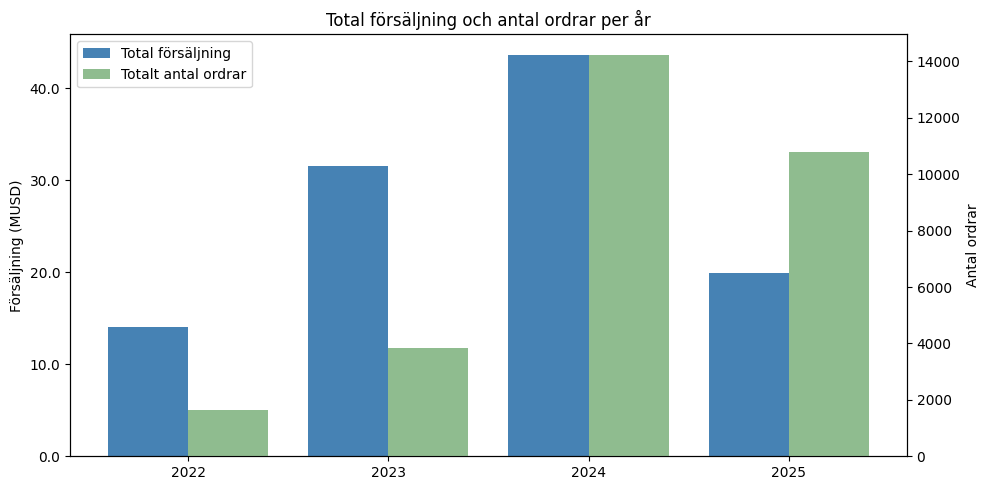

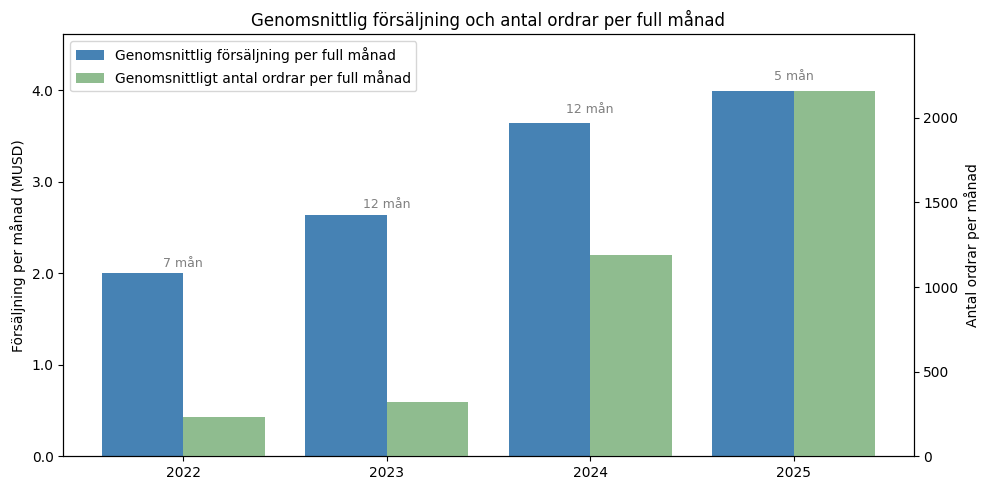

In [16]:
import numpy as np
import matplotlib.ticker as mtick

### Uppgift 4
# Försäljning och antal ordrar per år
# Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?

query_4=""" 
WITH Monthly AS (
    SELECT
        DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS OrderMonth,
        YEAR(OrderDate) AS OrderYear,
        SUM(SubTotal) AS TotalForsaljning,
        COUNT(*) AS AntalOrdrar,
        CASE
            WHEN MIN(CAST(OrderDate AS date)) = DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
             AND MAX(CAST(OrderDate AS date)) = EOMONTH(DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1))
            THEN 1 ELSE 0
        END AS IsFullMonth
    FROM Sales.SalesOrderHeader
    GROUP BY DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1), YEAR(OrderDate)
),
Yearly AS (
    SELECT
        OrderYear,

        -- Alla månader (oavsett full/inte)
        SUM(TotalForsaljning) AS TotalForsaljning_All,
        SUM(AntalOrdrar)      AS AntalOrdrar_All,
        COUNT(*)              AS Manader_All,

        -- Endast fulla månader
        SUM(CASE WHEN IsFullMonth = 1 THEN TotalForsaljning ELSE 0 END) AS TotalForsaljning_Full,
        SUM(CASE WHEN IsFullMonth = 1 THEN AntalOrdrar      ELSE 0 END) AS AntalOrdrar_Full,
        SUM(IsFullMonth) AS Manader_Full
    FROM Monthly
    GROUP BY OrderYear
)
SELECT *
FROM Yearly
ORDER BY OrderYear;
"""

df_4 = query_df(query_4)
df_4 = df_4.sort_values("OrderYear")

x = np.arange(len(df_4))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 5))

bars1 = ax1.bar(
    x - width/2,
    df_4["TotalForsaljning_Full"],
    width,
    color="steelblue"
) 

ax1.set_ylabel("Försäljning (MUSD)")
ax1.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f}")
)

ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    df_4["AntalOrdrar_Full"],
    width,
    color="darkseagreen"
)

ax2.set_ylabel("Antal ordrar")

ax1.legend([bars1[0], bars2[0]], ["Total försäljning", "Totalt antal ordrar"], loc="upper left")

ax1.set_xticks(x)
ax1.set_xticklabels(df_4["OrderYear"])

ax1.set_title("Total försäljning och antal ordrar per år")

plt.tight_layout()
plt.show()

# Åren innehåller olika antal fulla månader. För en mest enkel rättvisande bild, hur mycket säljer vi per full månad i genomsnitt? 

df_4["Genomsnitt_forsaljning_manad"] = (df_4["TotalForsaljning_Full"] / df_4["Manader_Full"])
df_4["Genomsnitt_ordrar_manad"] = (df_4["AntalOrdrar_Full"] / df_4["Manader_Full"])

fig, ax1 = plt.subplots(figsize=(10, 5))

# Staplar – försäljning (vänster axel)
bars1 = ax1.bar(
    x - width/2,
    df_4["Genomsnitt_forsaljning_manad"],
    width,
    color="steelblue"
)

ax1.set_ylabel("Försäljning per månad (MUSD)")
ax1.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f}")
)

# Andra axeln – ordrar
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    df_4["Genomsnitt_ordrar_manad"],
    width,
    color="darkseagreen"
)

ax2.set_ylabel("Antal ordrar per månad")

# X-axel
ax1.set_xticks(x)
ax1.set_xticklabels(df_4["OrderYear"])

# Legend 
ax1.legend([bars1[0], bars2[0]], ["Genomsnittlig försäljning per full månad", "Genomsnittligt antal ordrar per full månad"], loc="upper left")

# Visa hur många fulla månader varje år bygger på
for i, m in enumerate(df_4["Manader_Full"]):
    ax1.text(
        x[i],
        df_4["Genomsnitt_forsaljning_manad"].iloc[i] * 1.03,
        f"{int(m)} mån",
        ha="center",
        fontsize=9,
        color="gray"
    )

ax1.set_ylim(top=ax1.get_ylim()[1] * 1.1)
ax2.set_ylim(top=ax2.get_ylim()[1] * 1.1)

ax1.set_title("Genomsnittlig försäljning och antal ordrar per full månad")

plt.tight_layout()
plt.show()

## Slutsats
Eftersom endast 2023 och 2024 utgör fullständiga kalenderår är en jämförelse av totala årsvolymer mellan alla år missvisande utan hänsyn till antal ingående månader. Av de fullständiga åren har 2024 den högsta totala försäljningen samt det högsta antalet ordrar.

När försäljning och antal ordrar normaliseras till genomsnitt per full månad framgår att både försäljningen och antalet ordrar ökar över tid. Ökningen är dock relativt större för antalet ordrar än för försäljningen, vilket indikerar att det genomsnittliga ordervärdet per order minskar.

# -------------------Uppgift 5-------------------
**Vilka 10 produkter genererar mest försäljning?** (Top 10 produkter)

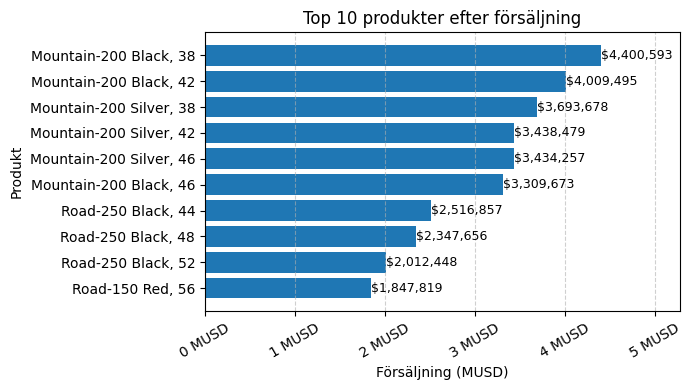

,TotalForsaljningPerProdukt,Produkt,Kategori,MedelPris_perOrderrad,MedelPris_vagt
0,"$4,400,593","Mountain-200 Black, 38",Bikes,"$1,730","$1,480"
1,"$4,009,495","Mountain-200 Black, 42",Bikes,"$1,776","$1,507"
2,"$3,693,678","Mountain-200 Silver, 38",Bikes,"$1,820","$1,544"
3,"$3,438,479","Mountain-200 Silver, 42",Bikes,"$1,812","$1,540"
4,"$3,434,257","Mountain-200 Silver, 46",Bikes,"$1,821","$1,551"
5,"$3,309,673","Mountain-200 Black, 46",Bikes,"$1,836","$1,568"
6,"$2,516,857","Road-250 Black, 44",Bikes,"$1,745","$1,534"
7,"$2,347,656","Road-250 Black, 48",Bikes,"$1,777","$1,568"
8,"$2,012,448","Road-250 Black, 52",Bikes,"$1,824","$1,616"
9,"$1,847,819","Road-150 Red, 56",Bikes,"$3,036","$2,783"


In [6]:
### Uppgift 5
# Top 10 produkter
# Affärsfråga: Vilka 10 produkter genererar mest försäljning?

query_5=""" 
SELECT TOP 10
    SUM(sod.LineTotal) AS TotalForsaljningPerProdukt,
    p.Name AS Produkt,
    pc.Name AS Kategori,
    AVG(sod.UnitPrice) AS MedelPris_perOrderrad,
    SUM(sod.UnitPrice * sod.OrderQty) / NULLIF(SUM(sod.OrderQty), 0) AS MedelPris_vagt --Utan discount
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p ON sod.ProductID = p.ProductID
LEFT JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.Name, pc.Name
ORDER BY SUM(sod.LineTotal) DESC;
"""

df_5 = query_df(query_5)
df_5

fig, ax = plt.subplots(figsize=(7, 4))

bars = ax.barh(
    df_5["Produkt"],
    df_5["TotalForsaljningPerProdukt"]
)

ax.set_title("Top 10 produkter efter försäljning")
ax.set_xlabel("Försäljning (MUSD)")
ax.set_ylabel("Produkt")

# Högsta värdet överst
ax.invert_yaxis()

# Vertikala hjälplinjer
ax.grid(axis="x", linestyle="--", alpha=0.6)

#Formattering x-axel
ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.0f} MUSD")
)

ax.tick_params(axis="x", rotation=30)

# Extra utrymme så texten inte kapas
max_value = df_5["TotalForsaljningPerProdukt"].max()
ax.set_xlim(0, max_value * 1.2)

# Lägg exakta värden på staplarna
for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"${width:,.0f}",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.show()
df_5_display = df_5.copy()

df_5_display.style.format({
    "TotalForsaljningPerProdukt": "${:,.0f} ",
    "MedelPris_perOrderrad": "${:,.0f} ",
    "MedelPris_vagt": "${:,.0f} "
})


## Slutsats
Mountain-200 Black, 38 är det produkt som har högst försäljningsvärde. Samtliga produkter på top-10-listan tillhör Kategorin cyklar(bikes). Medelvärdet för enhetspriset beräknades men är uträknad innan ytterligare discount är inlagd och jag tolkar nu att försäljningsvärde syftas på totalrad.  

Den produkt som genererar högst försäljning är Mountain-200 Black, 38 med 4,4 miljoner dollar. Samtliga produkter i topp 10 tillhör kategorin Bikes, vilket visar att cyklar dominerar försäljningen bland de mest intäktsgenererande produkterna.

För produkterna i topp 10 ligger det viktade medelpriset per enhet generellt något lägre än medelpriset per orderrad, vilket indikerar att större volymer säljs till lägre prisnivåer. Medelpriserna baseras på listpris (UnitPrice) och är beräknade före eventuell rabatt. Sammantaget visar analysen att ett relativt smalt sortiment av cykelmodeller står för en stor andel av den totala försäljningen.

# -------------------Uppgift 6-------------------
**Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?** (Försäljning och antal kunder per region)

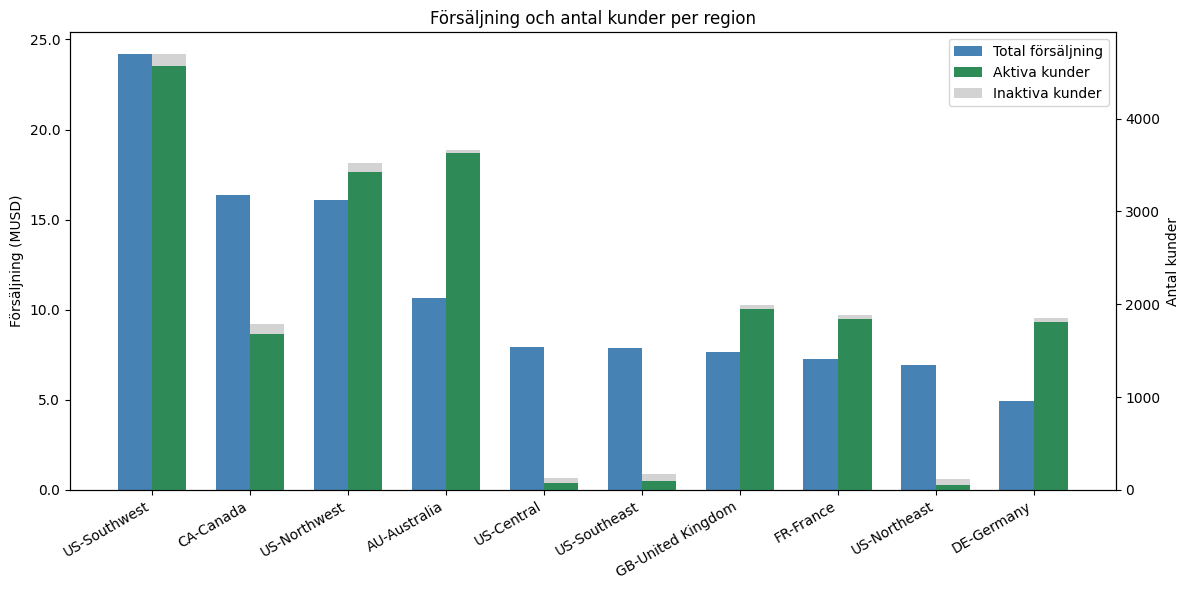

,Region,Total försäljning,Antal ordrar,Aktiva kunder,Inaktiva kunder,Unika kunder (totalt),Försäljning per aktiv kund
8,US-Northeast,"$6,939,374",352,57,56,113,"$121,743"
4,US-Central,"$7,909,009",385,69,63,132,"$114,623"
5,US-Southeast,"$7,879,655",486,91,85,176,"$86,590"
1,CA-Canada,"$16,355,770",4067,1677,114,1791,"$9,753"
0,US-Southwest,"$24,184,610",6224,4565,131,4696,"$5,298"
2,US-Northwest,"$16,084,943",4594,3428,92,3520,"$4,692"
7,FR-France,"$7,251,556",2672,1844,40,1884,"$3,933"
6,GB-United Kingdom,"$7,670,721",3219,1951,40,1991,"$3,932"
3,AU-Australia,"$10,655,336",6843,3625,40,3665,"$2,939"
9,DE-Germany,"$4,915,408",2623,1812,40,1852,"$2,713"


In [7]:
from matplotlib.patches import Patch

### Uppgift 6
# Försäljning och antal kunder per region
# Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

query_6=""" 
SELECT
    CONCAT(st.CountryRegionCode,'-', st.Name) AS Region,
    COALESCE(SUM(soh.SubTotal), 0) AS TotalForsaljningRegion,
    COUNT(DISTINCT c.CustomerID) AS UnikaKunderTotalt,
    COUNT(DISTINCT soh.CustomerID) AS UnikaKunderMedOrder,
    COUNT(DISTINCT soh.SalesOrderID) AS AntalOrdrar
FROM Sales.SalesTerritory st
LEFT JOIN Sales.Customer c
    ON c.TerritoryID = st.TerritoryID
LEFT JOIN Sales.SalesOrderHeader soh
    ON soh.CustomerID = c.CustomerID
GROUP BY st.CountryRegionCode, st.Name
ORDER BY TotalForsaljningRegion DESC;
"""
df_6 = query_df(query_6)

df_6 = df_6.sort_values("TotalForsaljningRegion", ascending=False)
df_6.head()

df_6["InaktivaKunder"] = (df_6["UnikaKunderTotalt"] - df_6["UnikaKunderMedOrder"])

x = np.arange(len(df_6))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))

#stapel 1(försäljning)
bars_sales = ax1.bar(
    x - width/2,
    df_6["TotalForsaljningRegion"],
    width,
    label="Total försäljning",
    color="steelblue"
)

ax1.set_ylabel("Försäljning (MUSD)")
ax1.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f}")
)

#Stapel 2 kunder(aktiva+inaktiva)
#för att få annan y-axel höger sida.
ax2 = ax1.twinx()

ax2.bar(
    x + width/2,
    df_6["UnikaKunderMedOrder"],
    width,
    label="Aktiva kunder",
    color="seagreen"
)

ax2.bar(
    x + width/2,
    df_6["InaktivaKunder"],
    width,
    bottom=df_6["UnikaKunderMedOrder"],
    label="Inaktiva kunder",
    color="lightgrey"
)

ax2.set_ylabel("Antal kunder")

ax1.set_xticks(x)
ax1.set_xticklabels(df_6["Region"], rotation=30, ha="right")

plt.title("Försäljning och antal kunder per region")

legend_handles = [
    Patch(facecolor="steelblue", label="Total försäljning"),
    Patch(facecolor="seagreen", label="Aktiva kunder"),
    Patch(facecolor="lightgrey", label="Inaktiva kunder")
]

ax1.legend(
    handles=legend_handles,
    loc="upper right"
)

plt.tight_layout()
plt.show()

df_6["ForsaljningPerAktivKund"] = df_6["TotalForsaljningRegion"]/df_6["UnikaKunderMedOrder"].replace(0, np.nan)

df_6_display=df_6.sort_values("ForsaljningPerAktivKund", ascending=False).copy()

cols = ["Region", "TotalForsaljningRegion", "AntalOrdrar", "UnikaKunderMedOrder", "InaktivaKunder", "UnikaKunderTotalt", "ForsaljningPerAktivKund"]
df_6_display=df_6_display[cols]

df_6_display = df_6_display.rename(columns={
    "TotalForsaljningRegion": "Total försäljning",
    "AntalOrdrar": "Antal ordrar",
    "UnikaKunderMedOrder": "Aktiva kunder",
    "InaktivaKunder": "Inaktiva kunder",
    "UnikaKunderTotalt": "Unika kunder (totalt)",
    "ForsaljningPerAktivKund": "Försäljning per aktiv kund",
})

#Markera max-raden
def highlight_max_sales(row):
    if row["Total försäljning"] == df_6_display["Total försäljning"].max():
        return ["font-weight: bold; color: orange"] * len(row)
    else:
        return [""] * len(row)

df_6_display.style \
    .apply(highlight_max_sales, axis=1) \
    .format({
    "Total försäljning": "${:,.0f} ",
    "Försäljning per aktiv kund": "${:,.0f} "
})


## Slutsats

US-Southwest är den starkaste regionen sett till både total försäljning och kundvolym, där resultatet främst drivs av ett stort antal kunder snarare än ett högt genomsnittligt ordervärde per kund.

Samtidigt uppvisar US-Northeast, US-Central och US-Southeast en hög försäljning per aktiv kund trots ett begränsat antal kunder, vilket indikerar att försäljningen i dessa regioner är koncentrerad till ett fåtal större affärer. Detta innebär hög intäkt per kund, men kan också medföra en ökad känslighet för förändringar i kundbasen.

Regioner i Europa och Australien uppvisar en bredare kundbas men lägre försäljning per kund, vilket tyder på en mer diversifierad försäljningsstruktur.

# -------------------Uppgift 7-------------------
**Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder** (Genomsnittligt ordervärde per region och kundtyp)

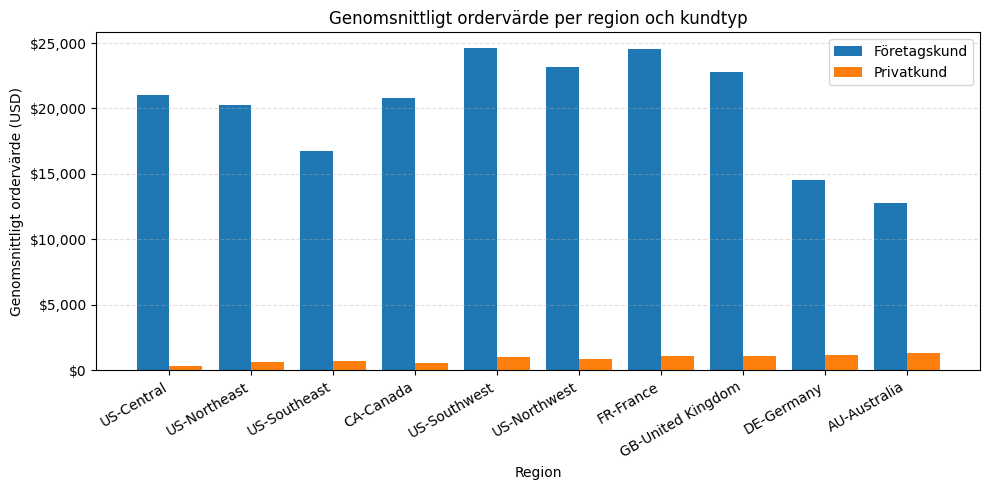

,Region,Kundtyp,AOV_Kundtyp,AOV_Totalt
8,US-Southwest,Företagskund,24589.159506,3885.702057
12,FR-France,Företagskund,24508.180495,2713.905557
10,US-Northwest,Företagskund,23199.768651,3501.293546
14,GB-United Kingdom,Företagskund,22760.685238,2382.951549
0,US-Central,Företagskund,21026.617491,20542.880536
6,CA-Canada,Företagskund,20777.349123,4021.581130
2,US-Northeast,Företagskund,20271.467875,19714.132049
4,US-Southeast,Företagskund,16774.874677,16213.282043
16,DE-Germany,Företagskund,14540.253653,1873.964009
18,AU-Australia,Företagskund,12754.683003,1557.114710


In [19]:
### Uppgift 7
# Genomsnittligt ordervärde per region och kundtyp
# Affärsfråga: Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

query_7=""" 
WITH Base AS (
    SELECT
        CONCAT(st.CountryRegionCode,'-', st.Name) AS Region,
        CASE
            WHEN c.StoreID IS NOT NULL THEN 'Företagskund'
            WHEN c.PersonID IS NOT NULL THEN 'Privatkund'
            ELSE 'Okänd'
        END AS Kundtyp,
        soh.SubTotal,
        soh.SalesOrderID
    FROM Sales.SalesOrderHeader soh
    JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
    JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
),
Agg AS (
    SELECT
        Region,
        Kundtyp,
        SUM(SubTotal) AS TotalForsaljning,
        COUNT(*) AS AntalOrdrar,
        SUM(SubTotal) * 1.0 / NULLIF(COUNT(*), 0) AS AOV_Kundtyp --1.0 gör så att det blir flyttalsdivision
    FROM Base
    GROUP BY Region, Kundtyp
),
RegionTotal AS (
    SELECT
        Region,
        SUM(TotalForsaljning) * 1.0 / NULLIF(SUM(AntalOrdrar), 0) AS AOV_Totalt
    FROM Agg
    GROUP BY Region
)
SELECT
    a.Region,
    a.Kundtyp,
    a.AOV_Kundtyp,
    rt.AOV_Totalt
FROM Agg a
JOIN RegionTotal rt ON a.Region = rt.Region
ORDER BY rt.AOV_Totalt DESC, a.Region, a.Kundtyp;
"""
df_7 = query_df(query_7)

# Regionordning enligt totalt genomsnitt (högst först)
region_order = (
    df_7[["Region", "AOV_Totalt"]]
    .drop_duplicates()
    .sort_values("AOV_Totalt", ascending=False)["Region"]
)


# Pivot för att få två staplar per region
pv = (df_7.pivot(index="Region", columns="Kundtyp", values="AOV_Kundtyp")
        .reindex(region_order))

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(pv.index))
width = 0.4

ax.bar(x - width/2, pv.get("Företagskund"), width, label="Företagskund")
ax.bar(x + width/2, pv.get("Privatkund"),  width, label="Privatkund")

ax.set_title("Genomsnittligt ordervärde per region och kundtyp")
ax.set_xlabel("Region")
ax.set_ylabel("Genomsnittligt ordervärde (USD)")
ax.set_xticks(x)
ax.set_xticklabels(pv.index, rotation=30, ha="right")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()

display(df_7.sort_values("AOV_Kundtyp", ascending=False))

## Slutsats
Företagskunder har genomgående ett betydligt högre genomsnittligt ordervärde än privatkunder i samtliga regioner. Detta kan förklaras av att företagskunder ofta genomför större och mer volymbaserade inköp, medan privatkunder i högre grad är slutkonsumenter som köper enskilda produkter eller mindre kvantiteter.

Det finns även tydliga regionala skillnader, särskilt bland företagskunder, där vissa regioner uppvisar högre genomsnittliga ordervärden än andra. Den högsta genomsnittliga orderstorleken återfinns hos företagskunder i US-Southwest, vilket indikerar att affärerna i denna region i genomsnitt är större än i övriga regioner.

Bland privatkunder är de genomsnittliga ordervärdena generellt låga i samtliga regioner, men DE-Germany utmärker sig med ett relativt högt ordervärde jämfört med övriga regioner, vilket tyder på att privatkunder där i genomsnitt gör något större köp.

Det totala genomsnittliga ordervärdet per region bör tolkas med försiktighet, eftersom det påverkas av fördelningen mellan kundtyper. Regioner med en hög andel privatkunder kan därför uppvisa ett lägre totalt genomsnittligt ordervärde, trots att den totala försäljningen är betydande.

# ----ALTERNATIV A: Regional försäljningsoptimering----
**Vilken region presterar bäst/sämst?** 

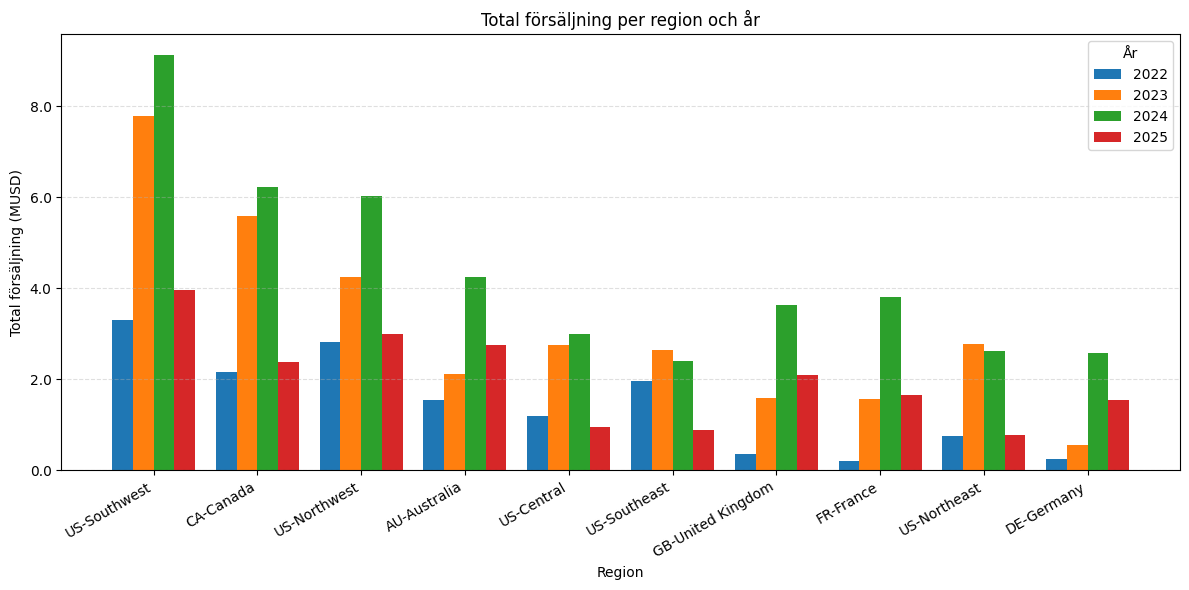

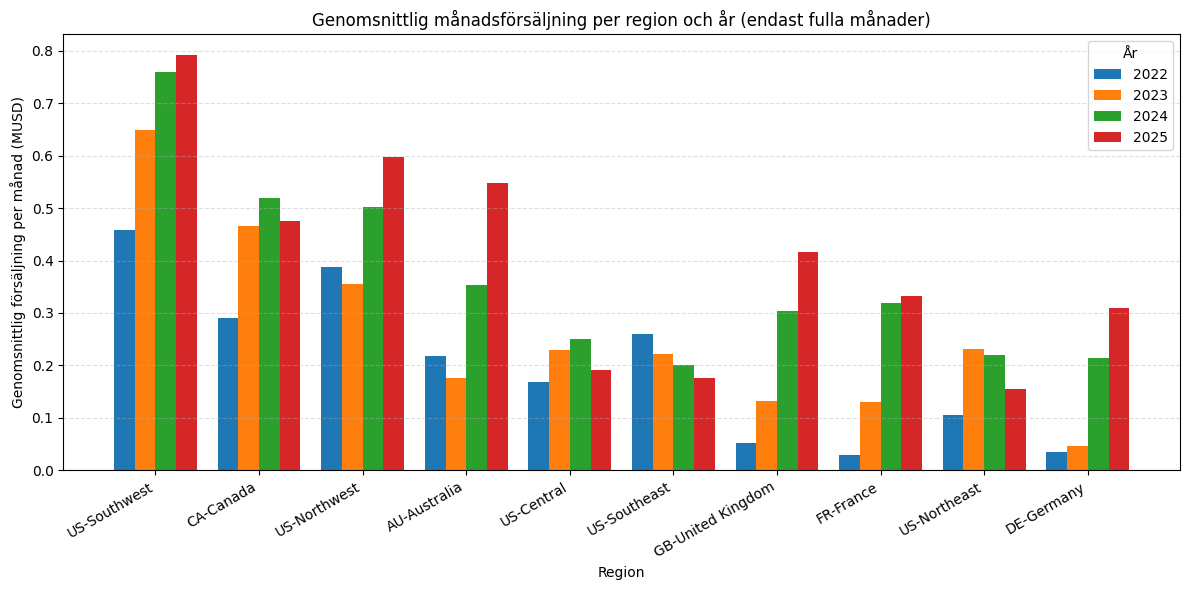

In [9]:
## ALTERNATIV A: Regional försäljningsoptimering
## Vilken region presterar bäst/sämst?

query_A1="""
WITH Monthly AS (
    SELECT
        CONCAT(st.CountryRegionCode,'-', st.Name) AS Region,
        DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS OrderMonth,
        YEAR(OrderDate) AS OrderYear,
        SUM(SubTotal) AS TotalForsaljning
        --COUNT(*) AS AntalOrdrar,
        --CASE
            --WHEN MIN(CAST(OrderDate AS date)) = DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
             --AND MAX(CAST(OrderDate AS date)) = EOMONTH(DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1))
            --THEN 1 ELSE 0
        --END AS IsFullMonth
    FROM Sales.SalesOrderHeader soh
    JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
    GROUP BY 
        CONCAT(st.CountryRegionCode,'-', st.Name),
        DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1), 
        YEAR(OrderDate) 
),
MonthlyFlag AS (
    SELECT
        m.*,
        CASE
            WHEN m.OrderMonth > MIN(m.OrderMonth) OVER ()
             AND m.OrderMonth < MAX(m.OrderMonth) OVER ()
            THEN 1 ELSE 0
        END AS IsFullMonth
    FROM Monthly m
),
Yearly AS (
    SELECT
        Region,
        OrderYear,

        -- Alla månader (oavsett full/inte)
        SUM(TotalForsaljning) AS TotalForsaljning_All,
        --SUM(AntalOrdrar) AS AntalOrdrar_All,
        COUNT(*) AS Manader_All,

        -- Endast fulla månader
        SUM(CASE WHEN IsFullMonth = 1 THEN TotalForsaljning ELSE 0 END) AS TotalForsaljning_Full,
        --SUM(CASE WHEN IsFullMonth = 1 THEN AntalOrdrar      ELSE 0 END) AS AntalOrdrar_Full,
        SUM(IsFullMonth) AS Manader_Full
    FROM MonthlyFlag
    GROUP BY Region, OrderYear
)
SELECT *
FROM Yearly
ORDER BY Region, OrderYear;
"""

df_A1 =query_df(query_A1)

#För sortering (total försäljning per år)
region_order = (
    df_A1.groupby("Region")["TotalForsaljning_All"]
      .sum()
      .sort_values(ascending=False)
      .index
)

pv = (
    df_A1.pivot(
        index="Region",
        columns="OrderYear",
        values="TotalForsaljning_All"
    )
    .reindex(region_order)
)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(pv.index))
width = 0.8 / len(pv.columns) #Beror på antal år

for i, year in enumerate(pv.columns):
    ax.bar(
        x + i * width,
        pv[year],
        width,
        label=str(year)
    )

ax.set_xticks(x + width * (len(pv.columns) - 1) / 2)
ax.set_xticklabels(pv.index, rotation=30, ha="right")

ax.set_title("Total försäljning per region och år")
ax.set_xlabel("Region")
ax.set_ylabel("Total försäljning (MUSD)")
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f}")
)

ax.legend(title="År")
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

#-----------------------------------------------------------------
#Normalisera för att åren inte är fulla
#-----------------------------------------------------------------
#Fulla månader har definierats globalt för hela datasetet för att säkerställa ett gemensamt och jämförbart tidsfönster mellan regioner.

df_A1a = df_A1.copy()
df_A1a["AvgForsaljning_Per_FullMonth"] = (
    df_A1a["TotalForsaljning_Full"] / df_A1a["Manader_Full"]
)

# region_order = (
#     df_A1a.groupby("Region")["AvgForsaljning_Per_FullMonth"]
#       .sum()
#       .sort_values(ascending=False)
#       .index
# )

#Sortera regionerna efter högsta totalförsäljning, då samma antal fullmånader används, så blir ingen skillnad
region_order = (
    df_A1a.groupby("Region")["TotalForsaljning_Full"]
      .sum()
      .sort_values(ascending=False)
      .index
)


pv = (
    df_A1a.pivot(
        index="Region",
        columns="OrderYear",
        values="AvgForsaljning_Per_FullMonth"
    )
    .reindex(region_order)
)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(pv.index))
width = 0.8 / len(pv.columns) #Beror på antal år

for i, year in enumerate(pv.columns):
    ax.bar(
        x + i * width,
        pv[year],
        width,
        label=str(year)
    )

ax.set_xticks(x + width * (len(pv.columns) - 1) / 2)
ax.set_xticklabels(pv.index, rotation=30, ha="right")

ax.set_title("Genomsnittlig månadsförsäljning per region och år (endast fulla månader)")
ax.set_xlabel("Region")
ax.set_ylabel("Genomsnittlig försäljning per månad (MUSD)")
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f}")
)

ax.legend(title="År")
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()




## Slutsats

Analysen visar att US-Southwest är den starkast presterande regionen, medan DE-Germany är den svagast presterande regionen under hela perioden. Skillnaderna mellan dessa regioner är tydliga och återfinns konsekvent under samtliga ingående år.

När utvecklingen över tid analyseras med hjälp av genomsnittlig månadsförsäljning per full månad framgår att flertalet regioner uppvisar en positiv trend, där den genomsnittliga månadsförsäljningen ökar år för år. Detta gäller exempelvis både US-Southwest och DE-Germany. Majoriteten av regionerna visar en positiv utveckling, och fyra av tio regioner uppvisar en strikt positiv trend på årsbasis. Tidigare analyser på månadsnivå indikerade endast en svag positiv trend, men med hänsyn till att det sista året innehåller de svagaste månaderna stärker detta slutsatsen att den övergripande trenden är positiv och inte ett resultat av felaktig viktning till följd av säsongsvariation.

Ett tydligt undantag är US-Southeast, som uppvisar en motsatt utveckling. I denna region minskar den genomsnittliga månadsförsäljningen successivt mellan åren, vilket indikerar en negativ trend trots att övriga regioner utvecklas positivt. Sammantaget visar analysen att normalisering per full månad inte bara bekräftar nivåskillnader mellan regioner, utan även möjliggör identifiering av skillnader i utvecklingstrend över tid.


# ----Fortsättning: Regional försäljningsoptimering----
**Vilka produktkategorier säljer bäst var?** 

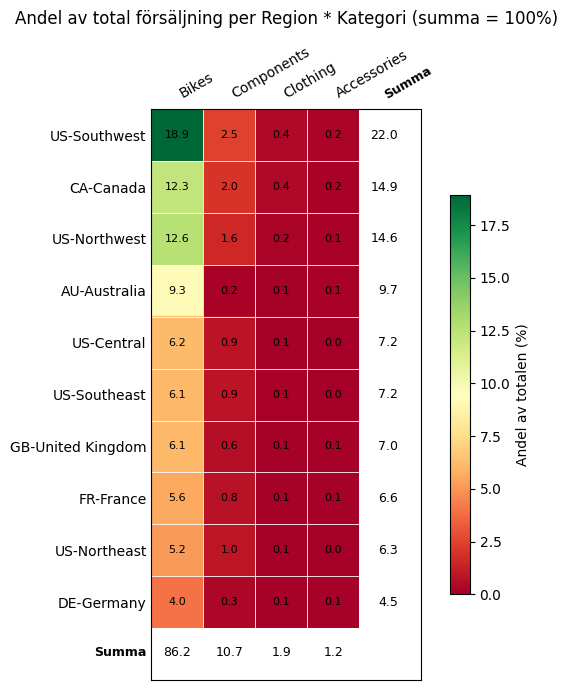

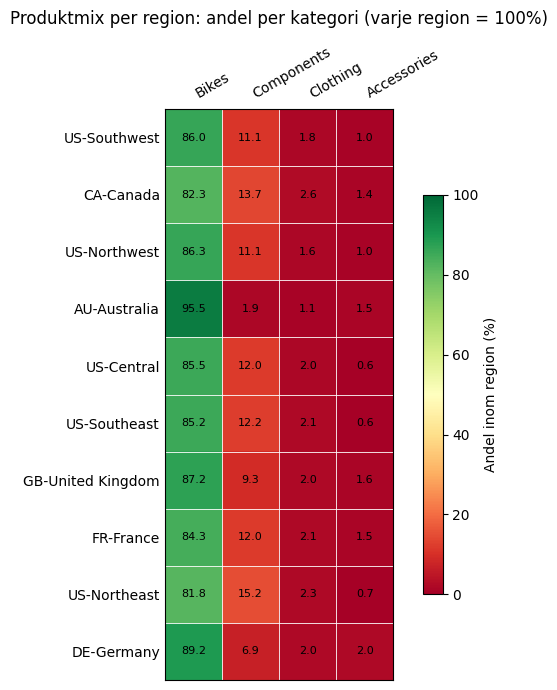

In [ ]:
## ALTERNATIV A: Regional försäljningsoptimering
## 	Vilka produktkategorier säljer bäst var?

query_A2="""
WITH Base AS (
    SELECT 
        CONCAT(st.CountryRegionCode,'-', st.Name) AS Region, 
        COALESCE(pc.Name, 'Saknar kategori') AS Kategori,
        SUM(sod.LineTotal) AS SummaKategori
    FROM Sales.SalesOrderDetail sod
    INNER JOIN Production.Product p
        ON sod.ProductID = p.ProductID
    LEFT JOIN Production.ProductSubcategory ps 
        ON p.ProductSubcategoryID = ps.ProductSubcategoryID
    LEFT JOIN Production.ProductCategory pc 
        ON ps.ProductCategoryID = pc.ProductCategoryID
    INNER JOIN Sales.SalesOrderHeader soh 
        ON sod.SalesOrderID = soh.SalesOrderID
    INNER JOIN Sales.SalesTerritory st
        ON soh.TerritoryID = st.TerritoryID
    GROUP BY 
        CONCAT(st.CountryRegionCode,'-', st.Name),
        COALESCE(pc.Name, 'Saknar kategori')
),
WithTotals AS (
    SELECT *,
        SUM(SummaKategori) OVER (PARTITION BY Region)   AS RegionTotal,
        SUM(SummaKategori) OVER (PARTITION BY Kategori) AS KategoriTotal
    FROM Base
)
SELECT *
FROM WithTotals
ORDER BY
    RegionTotal DESC,
    KategoriTotal DESC;
"""

df_A2 = query_df(query_A2)

#------------------------------------------
# Pivot: Region x Kategori (absoluta tal)
# ------------------------------------------
matris = (df_A2.pivot_table(
    index="Region", columns="Kategori", values="SummaKategori",
    aggfunc="sum", fill_value=0
))

# Sortera rader/kolumner efter totals (mest överst / mest till vänster)
matris = matris.reindex(
    index=matris.sum(axis=1).sort_values(ascending=False).index,
    columns=matris.sum(axis=0).sort_values(ascending=False).index
)

# Normalisera så att tabellen summerar 100%, matris_share i %
grand_total = matris.to_numpy().sum()
if grand_total == 0:
    matris_share = matris * 0
else:
    matris_share = matris / grand_total * 100

# Totals separat (ska inte påverka färgskalan i heatmap)
core = matris_share.copy()       # endast Region×Kategori
row_sum = core.sum(axis=1)       # regionens andel av totalen
col_sum = core.sum(axis=0)       # kategorins andel av totalen

# -----------------------------
# Rita heatmap (core endast)
# -----------------------------
fig, ax = plt.subplots(
    figsize=(max(6, 0.8 * core.shape[1] + 3),
             max(5, 0.4 * core.shape[0] + 3))
)

#färgar varje cell efter värdet i core
im = ax.imshow(core.values, cmap="RdYlGn", vmin=0, vmax=core.values.max())

# Axlar
ax.set_xticks(np.arange(core.shape[1]))
ax.set_yticks(np.arange(core.shape[0]))
ax.set_xticklabels(core.columns, rotation=30, ha="left")
ax.set_yticklabels(core.index)

# Kategorier uppe
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
#ax.set_xlabel("Kategori")
#ax.set_ylabel("Region")
ax.set_title("Andel av total försäljning per Region * Kategori (summa = 100%)", pad=15)

# Ta bort små svarta tick-streck (både x och y)
ax.tick_params(axis="x", which="both", length=0, pad=6)
ax.tick_params(axis="y", which="both", length=0)

# Rutlinjer (cellkanter)
ax.set_xticks(np.arange(-0.5, core.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, core.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.6)
ax.tick_params(which="minor", left=False, bottom=False)

# Skriv %-tal i varje ruta
for i in range(core.shape[0]):
    for j in range(core.shape[1]):
        ax.text(j, i, f"{core.iat[i, j]:.1f}", ha="center", va="center",
                fontsize=8, color="black")

# --------------------------------------------
# Skriv totals utanför (höger & nederkant)
# --------------------------------------------
# Referenspunkter för heatmapens kant
right_edge  = core.shape[1] - 0.5
bottom_edge = core.shape[0] - 0.5

# Höger sida: radsummor
x_numbers = right_edge + 0.75   # siffror nära heatmap
x_label   = right_edge + 0.95   # rubrik lite längre ut

for i, v in enumerate(row_sum.values):
    ax.text(x_numbers, i, f"{v:.1f}",
            va="center", ha="right", fontsize=9)

ax.text(x_label, -0.65, "Summa",
        rotation=30, va="bottom", ha="center",
        fontsize=9, fontweight="bold")

# Nederkant: kolumnsummor
y_numbers = bottom_edge + 0.35
y_label   = bottom_edge + 0.35 

for j, v in enumerate(col_sum.values):
    ax.text(j, y_numbers, f"{v:.1f}",
            ha="center", va="top", fontsize=9)

ax.text(-0.6, y_label, "Summa",
        ha="right", va="top",
        fontsize=9, fontweight="bold")

# Ge plats för totals
ax.set_xlim(-0.5, right_edge + 1.2)
ax.set_ylim(bottom_edge + 1.0, -0.5)

#Colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("Andel av totalen (%)")

plt.tight_layout()
plt.show()

# ============================================================
# HEATMAP 2: "Vilka produktkategorier säljer bäst var?"
#           = Region-MIX (varje regionrad summerar till 100%)
# ============================================================
row_totals = matris.sum(axis=1) #total försäljning per region
core2 = matris.div(row_totals.replace(0, np.nan), axis=0).fillna(0) * 100 #delar varje rad med regionsumman

fig, ax = plt.subplots(
    figsize=(max(6, 0.8 * core2.shape[1] + 3),
             max(5, 0.4 * core2.shape[0] + 3))
)

#färgar varje cell efter värdet i core2, Region summa = 100 så vmax 100
im = ax.imshow(core2.values, cmap="RdYlGn", vmin=0, vmax=100)

ax.set_xticks(np.arange(core2.shape[1]))
ax.set_yticks(np.arange(core2.shape[0]))
ax.set_xticklabels(core2.columns, rotation=30, ha="left")
ax.set_yticklabels(core2.index)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_title("Produktmix per region: andel per kategori (varje region = 100%)", pad=15)

ax.tick_params(axis="x", which="both", length=0, pad=6)
ax.tick_params(axis="y", which="both", length=0)

ax.set_xticks(np.arange(-0.5, core2.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, core2.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.6)
ax.tick_params(which="minor", left=False, bottom=False)

# Skriver %-tal i varje ruta
for i in range(core2.shape[0]):
    for j in range(core2.shape[1]):
        ax.text(j, i, f"{core2.iat[i, j]:.1f}", ha="center", va="center",
                fontsize=8, color="black")

#Colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("Andel inom region (%)")

plt.tight_layout()
plt.show()

## Slutsats
Analysen visar att Bikes dominerar försäljningen i samtliga regioner, där kategorin står för över 80 % av försäljningen i varje region. Components är konsekvent den näst största kategorin och uppvisar ett likartat mönster mellan regionerna, medan Clothing och Accessories endast utgör en marginell andel. Detta är logiskt för ett cykelföretag, där huvudprodukten är cyklar, följt av komponenter såsom reservdelar, medan kläder och tillbehör spelar en mer kompletterande roll.

Den globala analysen visar samtidigt tydliga skillnader i var den totala omsättningen genereras. Särskilt framträdande är US-Southwest, där Bikes ensamt står för närmare 20 % av företagets totala omsättning. Detta understryker inte bara cyklar som den viktigaste produktkategorin, utan också US-Southwest som en strategiskt central region för företagets övergripande försäljning.

# ----Fortsättning: Regional försäljningsoptimering----
**•	Finns säsongsmönster per region?** 

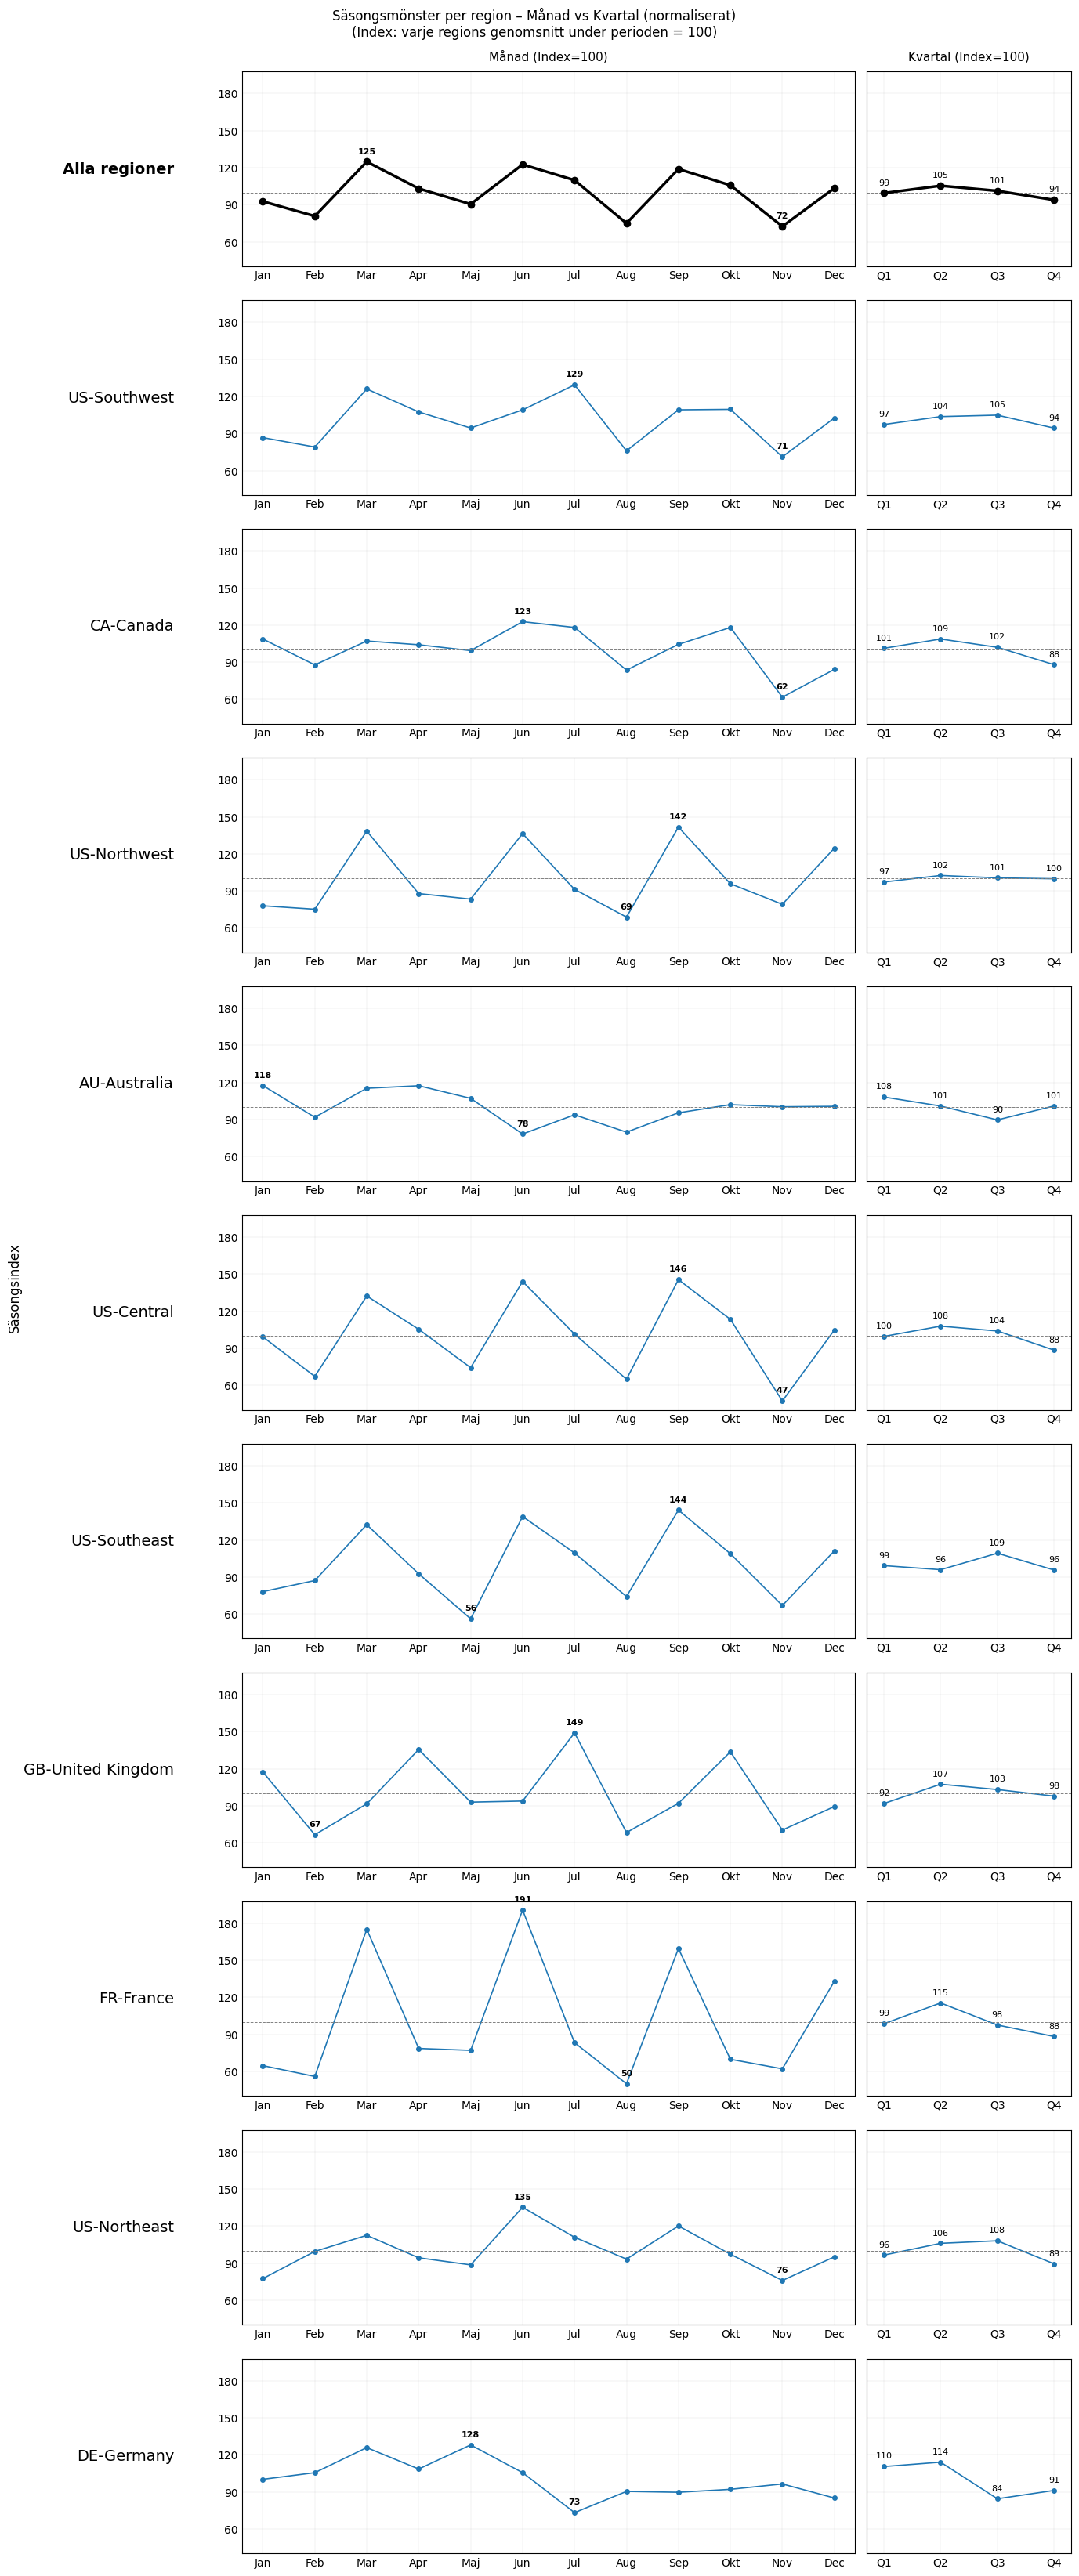

In [11]:
## ALTERNATIV A: Regional försäljningsoptimering
##  Finns säsongsmönster per region?

query_A3="""
WITH Monthly AS (
    SELECT
        CONCAT(st.CountryRegionCode, '-', st.Name) AS Region,
        DATEFROMPARTS(YEAR(soh.OrderDate), MONTH(soh.OrderDate), 1) AS OrderMonth,
        YEAR(soh.OrderDate)  AS OrderYear,
        MONTH(soh.OrderDate) AS OrderMonthNum,
        SUM(soh.SubTotal) AS TotalForsaljning
    FROM Sales.SalesOrderHeader soh
    JOIN Sales.SalesTerritory st
        ON soh.TerritoryID = st.TerritoryID
    GROUP BY
        CONCAT(st.CountryRegionCode, '-', st.Name),
        DATEFROMPARTS(YEAR(soh.OrderDate), MONTH(soh.OrderDate), 1),
        YEAR(soh.OrderDate),
        MONTH(soh.OrderDate)
)
SELECT *
FROM Monthly
-- Ta bort första och sista månaden, då vi sedan tidigare vet att de är ofullständiga
WHERE OrderMonth > (SELECT MIN(OrderMonth) FROM Monthly)
  AND OrderMonth < (SELECT MAX(OrderMonth) FROM Monthly)
ORDER BY Region, OrderYear, OrderMonthNum;
"""
# ----------------------------
# Månad: medel per månad + index=100
# ----------------------------

df_A3 = query_df(query_A3)

# Total
df_total_month = (
    df_A3
    .groupby("OrderMonthNum", as_index=False)["TotalForsaljning"]
    .mean()
)

df_total_month["SeasonIndexM"] = (
    df_total_month["TotalForsaljning"] /
    df_total_month["TotalForsaljning"].mean()
) * 100

df_total_month["Region"] = "Alla regioner"

# Respektive region
df_avg = (
    df_A3
    .groupby(["Region", "OrderMonthNum"], as_index=False)["TotalForsaljning"]
    .mean()
)

df_avg["SeasonIndexM"] = (
    df_avg["TotalForsaljning"] /
    df_avg.groupby("Region")["TotalForsaljning"].transform("mean")
) * 100

# Regionordning efter total försäljning
regions = (
    df_A3
    .groupby("Region")["TotalForsaljning"]
    .sum()
    .sort_values(ascending=False)
    .index
    .tolist()
)
regions_with_total = ["Alla regioner"] + regions

# ----------------------------
# Kvartal: medel per kvartal + index=100
# ----------------------------
#Total
df_total_q = (
    df_A3
    .assign(Quarter=((df_A3["OrderMonthNum"] - 1) // 3) + 1)
    .groupby("Quarter", as_index=False)["TotalForsaljning"]
    .mean()
)

df_total_q["SeasonIndexQ"] = (
    df_total_q["TotalForsaljning"] /
    df_total_q["TotalForsaljning"].mean()
) * 100

df_total_q["Region"] = "Alla regioner"

#Respektive region
df_q = df_A3.copy()
df_q["Quarter"] = ((df_q["OrderMonthNum"] - 1) // 3) + 1

df_qavg = (
    df_q
    .groupby(["Region", "Quarter"], as_index=False)["TotalForsaljning"]
    .mean()
)

df_qavg["SeasonIndexQ"] = (
    df_qavg["TotalForsaljning"] /
    df_qavg.groupby("Region")["TotalForsaljning"].transform("mean")
) * 100

# Snabb access per region (slipper filtrera fram och tillbaka)
avgM = {r: g.sort_values("OrderMonthNum") for r, g in df_avg.groupby("Region")}
avgQ = {r: g.sort_values("Quarter")      for r, g in df_qavg.groupby("Region")}

#Lägg till Total
avgM["Alla regioner"] = df_total_month.sort_values("OrderMonthNum")
avgQ["Alla regioner"] = df_total_q.sort_values("Quarter")

# ----------------------------
# Subplots: 2 kolumner (Månad | Kvartal), en rad per region
# ----------------------------
nrows = len(regions_with_total)
ncols=2
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, 3.0 * nrows),
    sharey=True,
    gridspec_kw={"width_ratios": [3, 1]}
)

month_labels = ["Jan", "Feb", "Mar", "Apr", "Maj", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dec"]
quarter_labels = ["Q1", "Q2", "Q3", "Q4"]

for i, region in enumerate(regions_with_total):
    axM = axes[i, 0]  # vänster: månad
    axQ = axes[i, 1]  # höger: kvartal
    
    is_all = (region == "Alla regioner")

    # --- Månad ---
    sM = avgM.get(region)
    if sM is not None and not sM.empty:
        axM.plot(sM["OrderMonthNum"], 
            sM["SeasonIndexM"], 
            marker="o",
            markersize=6 if is_all else 4, 
            linewidth=2.5 if is_all else 1.2,
            color="black" if is_all else "#1f77b4",  # svart för Alla regioner)
            zorder=3 if is_all else 2
        )
    # index för max och min
    imax = sM["SeasonIndexM"].idxmax()
    imin = sM["SeasonIndexM"].idxmin()

    for idx in [imax, imin]:
        x = sM.loc[idx, "OrderMonthNum"]
        y = sM.loc[idx, "SeasonIndexM"]
        axM.annotate(f"{y:.0f}", (x, y),
                 textcoords="offset points", xytext=(0, 6),
                 ha="center", va="bottom", fontsize=8, fontweight="bold")

    axM.axhline(100, color="gray", linestyle="--", linewidth=0.7)
    axM.set_yticks(np.arange(60, 181, 30))  # 60–180 med steg 20
    axM.set_xlim(0.6, 12.4)
    axM.set_xticks(range(1, 13))
    axM.set_xticklabels(month_labels)
    axM.grid(True, linewidth=0.25, alpha=0.5)

    # Sätt regionnamn som y-label på vänsterkolumnen (renare än title överallt)
    axM.set_ylabel(region, rotation=0, ha="right", va="center", labelpad=40, fontsize=14, fontweight="bold" if is_all else "normal")

    # --- Kvartal ---
    sQ = avgQ.get(region)
    if sQ is not None and not sQ.empty:
        axQ.plot(sQ["Quarter"], 
            sQ["SeasonIndexQ"], 
            marker="o",
            markersize=6 if is_all else 4, 
            linewidth=2.5 if is_all else 1.2,
            color="black" if is_all else "#1f77b4",
            zorder=3 if is_all else 2
        )
    
    for x, y in zip(sQ["Quarter"], sQ["SeasonIndexQ"]):
        axQ.annotate(f"{y:.0f}", (x, y),
                 textcoords="offset points", xytext=(0, 6),
                 ha="center", va="bottom", fontsize=8)

    axQ.axhline(100, color="gray", linestyle="--", linewidth=0.7)
    axQ.set_yticks(np.arange(60, 181, 30))  # 60–180 med steg 20
    axQ.set_xlim(0.7, 4.3)
    axQ.set_xticks([1, 2, 3, 4])
    axQ.set_xticklabels(quarter_labels)
    axQ.grid(True, linewidth=0.25, alpha=0.5)

    # Ta bort “små svarta tick-streck” om du vill
    axM.tick_params(axis="both", length=0)
    axQ.tick_params(axis="both", length=0)

# Kolumnrubriker
axes[0, 0].set_title("Månad (Index=100)", fontsize=11, pad=10)
axes[0, 1].set_title("Kvartal (Index=100)", fontsize=11, pad=10)

# Gemensam titel + y-label
fig.suptitle(
    "Säsongsmönster per region – Månad vs Kvartal (normaliserat)\n"
    "(Index: varje regions genomsnitt under perioden = 100)",
    y=0.995
)
fig.supylabel("Säsongsindex")

plt.tight_layout()
plt.show()

## Slutsats
Analysen visar att det finns tydliga säsongsmönster per region, där försäljningen generellt är starkast under Q2 och Q3, med särskilt hög nivå under Q2 (vår). Detta är ett förväntat och logiskt mönster för ett cykelföretag, då efterfrågan på cyklar och tillbehör naturligt ökar under vår- och sommarmånaderna när väderförhållandena är mer gynnsamma för cykling.

Eftersom säsongsindexet jämför varje månad med regionens genomsnittliga försäljning (index = 100), ligger vintermånadernas genomsnitt generellt betydligt under denna nivå. Detta resulterar i tydligare avvikelser från index 100 under lågsäsong jämfört med högsäsong. Samtidigt visar analysen att styrkan i säsongsmönstret varierar mellan regioner, där vissa regioner uppvisar större avvikelser från genomsnittet än andra, vilket indikerar att säsongseffekterna är regionalt betingade.

Vidare framgår att de tre största regionerna – US-Southwest, CA-Canada och US-Northwest – i stor utsträckning följer det övergripande säsongsmönstret för alla regioner sammantaget. Detta är rimligt då dessa regioner står för en betydande andel av den totala försäljningen och därmed i hög grad påverkar det globala mönstret.



## Rekommendationer för förbättring

Baserat på de identifierade säsongsmönstren per region rekommenderas att företaget i större utsträckning anpassar lager- och inköpsplanering regionalt, särskilt inför Q2 och Q3 då efterfrågan är som högst. De regioner som bidrar mest till den totala försäljningen, såsom US-Southwest, CA-Canada och US-Northwest, bör prioriteras vid planering av sortiment och marknadsinsatser. Samtidigt kan riktade kampanjer under lågsäsong användas i regioner med tydligare vinterdippar för att jämna ut försäljningen över året.

# Analysens avgränsningar
Denna analys fokuserar på försäljningsvolymer, kundstruktur och genomsnittliga ordervärden. Marginaler, lönsamhet och kostnadsaspekter har inte inkluderats, vilket innebär att slutsatserna inte säger något om produkters eller kunders faktiska lönsamhet. En analys av dessa aspekter har inte genomförts inom ramen för detta arbete.

